In [19]:
import cv2
import os
import numpy as np
from common import CV_DATASETS_DIR, show_full_image_plot
from pathlib import Path
from PIL import Image

TRAIN_IMAGES = CV_DATASETS_DIR / 'yalefaces' / 'train'
TESTS_IMAGES = CV_DATASETS_DIR / 'yalefaces' / 'test'

face_cascade = cv2.CascadeClassifier('/usr/share/opencv4/haarcascades/haarcascade_frontalface_alt.xml')
assert  not face_cascade.empty()

def get_image_label(filename: str) -> int:
    label = str()
    for ch in filename:
        if ch.isdigit():
            label += ch
    return int(label)

def get_image_data(file: Path, padding: int = 5, scale_factor: float = 1.1, min_neighbors:int = 5) -> np.array:
    image = np.array(Image.open(file).convert('L'), 'uint8')
    faces = face_cascade.detectMultiScale(image, scale_factor, min_neighbors)
    assert len(faces) == 1, \
        f"Expected only one face at <{file}> image: {len(faces)} vs 1"
    cropped_image = None
    for (x, y, w, h) in faces:
        # Crop image
        cropped_image = image[y - padding + 1 : y + h + padding, x - padding + 1 : x + w + padding]
        # Remove noise
        cv2.GaussianBlur(cropped_image, [7, 7], 0, image)
        # Equalize histogram
        cv2.equalizeHist(cropped_image, cropped_image)
    return cropped_image 

def get_images(path: Path) -> ([np.array], [int]):
    images = []
    labels = []
    for filename in os.listdir(path):
        file = Path(os.path.join(path, filename))
        if file.is_file():
            try:
                images.append(get_image_data(file))
                labels.append(get_image_label(filename))
            except OSError as e:
                print(f'Unable to read <{file}> file: {e.strerror}')
    return images, np.array(labels)

train_images, train_labels = get_images(TRAIN_IMAGES)
assert len(train_labels) == len(train_images), \
    f"The mount of labels and images must be equal: {len(train_labels)} vs {len(train_images)}"
tests_images, tests_labels = get_images(TESTS_IMAGES)
assert len(tests_labels) == len(tests_images), \
    f"The mount of labels and images must be equal: {len(tests_labels)} vs {len(tests_images)}"

In [20]:
# Train and save classifier
from common import CV_WORKAREA_DIR
classifier1 = cv2.face.LBPHFaceRecognizer.create()
classifier1.train(train_images, train_labels)
classifier1.write(str(CV_WORKAREA_DIR / 'lbph_classifier.yml'))

In [21]:
# Load classifier and recognize faces
classifier2 = cv2.face.LBPHFaceRecognizer.create()
classifier2.read(str(CV_WORKAREA_DIR / 'lbph_classifier.yml'))


predictions = []
expected = []
for image, label in zip(tests_images, tests_labels):
    predict, confidence = classifier2.predict(image)
    predictions.append(predict)
    expected.append(label)

predictions = np.array(predictions)
expected = np.array(expected)


Accuracy: 78.2%


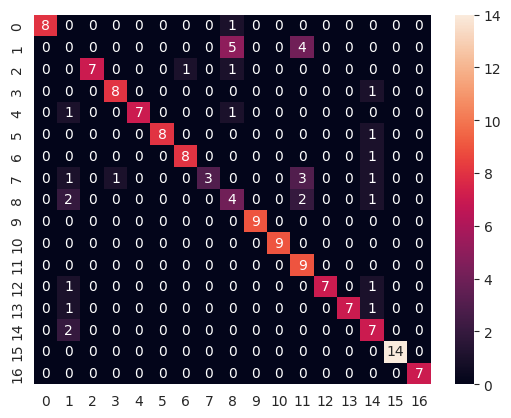

In [22]:
# Evaluate recognizing result
import seaborn
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(expected, predictions)
print(f'Accuracy: {accuracy * 100:.3}%')

cm = confusion_matrix(expected, predictions)
seaborn.heatmap(cm, annot=True);
